In [19]:
from collections import namedtuple
import cv2
import time
import os
import numpy as np
import sys
import torch
from tqdm import tqdm
from dress_code_data import DressCodeDatasetAnyDoor
# from utils import sem2onehot
import argparse
from matplotlib import pyplot as plt
import PIL
from torchvision.transforms import ToPILImage,Grayscale,ToTensor
from datasets.vitonhd import VitonHDDataset, VitonHDDataset_agnostic
from torch.utils.data import DataLoader, SubsetRandomSampler,Subset
import cv2
import random
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
from PIL import Image, ImageDraw
import os
import numpy as np
import json
from typing import List, Tuple
from dress_code_data.labelmap import label_map
from numpy.linalg import lstsq
from omegaconf import OmegaConf
import logging

logger = logging.getLogger(__name__)


In [20]:
torch.set_printoptions(threshold=1000)

In [21]:
def check_mask_area(mask, max_ratio=0.7, min_ratio=0.1):
    H, W = mask.shape[0], mask.shape[1]
    ratio = mask.sum() / (H * W)
    logger.info(f"Dimensions:{mask.shape}")
    logger.info(f"sum over the mask {mask.sum()}")
    logger.info(f"Ratio computed: {ratio}")
    if (ratio > max_ratio) or (ratio < min_ratio):
        logger.error(f"ratio computed: {ratio}")
        return False
    else:
        return True
    
    import numpy as np
import torch

def batch_check_mask_area(batch_masks, max_ratio=0.7, min_ratio=0.1):
    """
    Check if the area of each mask in a batch falls within the specified ratio bounds.

    Parameters:
    - batch_masks: A batch of masks with shape (N, H, W).
    - max_ratio: Maximum allowed ratio of mask area to total area.
    - min_ratio: Minimum allowed ratio of mask area to total area.

    Returns:
    - A list of boolean values indicating whether each mask meets the area criteria.
    """
    results = []
    for mask in batch_masks:
        H, W = mask.shape[0], mask.shape[1]  # Adjusted for batched masks
        ratio = mask.sum() / (H * W)
    
        if (ratio > max_ratio) or (ratio < min_ratio):
            logger.info(f"Ratio computed: {ratio}")
            results.append(False)
        else:
            results.append(True)
    
    return np.array(results)

def mask_score(mask):
    """Scoring the mask according to connectivity."""
    mask = mask.astype(np.uint8)
    if mask.sum() < 10:
        return 0
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cnt_area = [cv2.contourArea(cnt) for cnt in contours]
    conc_score = np.max(cnt_area) / sum(cnt_area)
    if conc_score < 0.9:
        logger.error(f"mask score under the threshold: {conc_score}")
    return conc_score


def batch_mask_score(batch_masks):
    """
    Compute the mask score for a batch of masks.
    
    Parameters:
    - batch_masks: A batch of masks as a numpy array or a PyTorch tensor.
                   Shape should be (N, H, W) where N is the batch size.
    
    Returns:
    - scores: A numpy array or PyTorch tensor of scores for each mask in the batch.
    """
    scores = []
    for mask in batch_masks:
        mask = mask.numpy().astype(np.uint8) if isinstance(mask, torch.Tensor) else mask.astype(np.uint8)
        if mask.sum() < 10:
            scores.append(0)
            continue
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        cnt_area = [cv2.contourArea(cnt) for cnt in contours]
        conc_score = np.max(cnt_area) / sum(cnt_area) if sum(cnt_area) > 0 else 0
        if conc_score < 0.9:
            # Assuming `logger` is defined elsewhere.
            logger.info(f"mask score under the threshold: {conc_score}")
        scores.append(conc_score)
    
    return np.array(scores)

def check_mask_area(self, mask, max_ratio=0.7, min_ratio=0.01):
        H, W = mask.shape[0], mask.shape[1]
        ratio = mask.sum() / (H * W)
        logger.info(f"Dimensions:{mask.shape}")
        logger.info(f"sum over the mask {mask.sum()}")
        logger.info(f"Ratio computed: {ratio}")
        if (ratio > max_ratio) or (ratio < min_ratio):
            logger.error(f"ratio computed: {ratio}")
            return False
        else:
            return True
        
        
def check_region_size(self, image, yyxx, ratio, mode="max"):
    pass_flag = True
    H, W = image.shape[0], image.shape[1]
    H, W = H * ratio, W * ratio
    y1, y2, x1, x2 = yyxx
    h, w = y2 - y1, x2 - x1
    if mode == "max":
        if h > H or w > W:
            pass_flag = False
    elif mode == "min":
        if h < H or w < W:
            pass_flag = False
    return pass_flag
    
def batch_check_region_size(batch_images, batch_yyxx, ratio, mode="max"):
    """
    Check if the regions of each image in a batch are within specified size constraints.
    
    Parameters:
    - batch_images: A batch of images with shape (N, H, W, C) or (N, H, W) where
                    N is the batch size, H and W are the dimensions of the images,
                    and C is the number of channels (if present).
    - batch_yyxx: A list or array of region coordinates for each image in the batch,
                  with each element being [y1, y2, x1, x2].
    - ratio: A float representing the ratio of the region size to the image size.
    - mode: A string, either "max" or "min", indicating the type of size check.
    
    Returns:
    - A numpy array of boolean values indicating whether each region in the batch meets the size criteria.
    """
    pass_flags = []
    for image, yyxx in zip(batch_images, batch_yyxx):
        H, W = image.shape[0], image.shape[1]
        H, W = H * ratio, W * ratio
        y1, y2, x1, x2 = yyxx
        h, w = y2 - y1, x2 - x1
        pass_flag = True
        if mode == "max":
            if h > H or w > W:
                pass_flag = False
        elif mode == "min":
            if h < H or w < W:
                pass_flag = False
        pass_flags.append(pass_flag)
    return np.array(pass_flags)


def get_bbox_from_mask(mask):
    h, w = mask.shape[0], mask.shape[1]

    if mask.sum() < 10:
        return 0, h, 0, w
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    y1, y2 = np.where(rows)[0][[0, -1]]
    x1, x2 = np.where(cols)[0][[0, -1]]
    return (y1, y2, x1, x2)

In [22]:
def main_worker(args):

    # Dataset & Dataloader
    dataset_train = DressCodeDatasetAnyDoor(
        args,
        dataroot_path=args.dataroot,
        phase="train",
        order="paired",
        size=(int(args.height), int(args.width)),
    )
    total_data = len(dataset_train)
    subset_size = total_data // 100
    print("dataset size:", subset_size)

    # Generate a random sample of indexes for the subset
    random_indexes = random.sample(range(total_data), subset_size)
    
    # indexes = list(range(44000, len(dataset_train)))
    # subset_size = len(indexes)
    
    print("dataset size:", subset_size)


    # Creating a subset of the original dataset using the randomly selected indexes
    random_subset_dataset_train = Subset(dataset_train, random_indexes)

    #indexes = list(range(40000, len(dataset_train)))
    #dataset_train = Subset(dataset_train, indexes)
    dataloader_train = torch.utils.data.DataLoader(random_subset_dataset_train, batch_size=8, shuffle=True, num_workers=4)

    return dataloader_train



In [23]:
args = argparse.Namespace(batch_size=1, category='all', checkpoint_dir='', data_pairs='{}_pairs', dataroot='/home/ubuntu/volume240/DressCode', display_count=1000, epochs=150, exp_name='', height=1024, radius=5, shuffle=True, step=100000, width=768, workers=0)

# Call main worker
dataloader_train  = main_worker(args)
sample_it  = iter(dataloader_train)

dataset size: 483


In [24]:
def process_batches(dataloader):
    incorrect_masks_count = 0
    total_batches = len(dataloader)
    print("Processing batches...")

    for batch_idx, batch in enumerate(dataloader):
        # Assuming batch['ref_mask'] is a tensor here
        masks = batch["ref_mask"]
        model_masks = batch["model_mask"]
        boxes = [get_bbox_from_mask(mask) for mask in np.array(batch["ref_mask"])]
        
        unconnected_masks = batch_mask_score(masks) < 0.9
        wrong_size_masks = ~batch_check_mask_area(masks)
        wrong_size_model_masks = ~batch_check_mask_area(model_masks)
        wrong_size_boxes = ~batch_check_region_size(batch["ref_image"],batch_yyxx = boxes, ratio = 0.1 , mode = "min")
        
        # print(f"unconnected_masks sizes: {unconnected_masks.shape}, wrong_size_masks sizes: {wrong_size_masks.shape}", )
        incorrect_masks_count += np.sum( wrong_size_boxes )
        
        # Progress update
        progress = (batch_idx + 1) / total_batches * 100
        print(f'\r[{("=" * int(progress // 2)) + (" " * (50 - int(progress // 2)))}] {progress:.2f}%', end='')

    print("\nFinished processing. Checks not passed: ",incorrect_masks_count )
    
    return incorrect_masks_count


In [25]:
process_batches(dataloader_train)

Processing batches...


/home/ubuntu/mnt/myData/AnyDoor/.venv/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/ubuntu/mnt/myData/AnyDoor/.venv/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None t

/home/ubuntu/mnt/myData/AnyDoor/.venv/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/ubuntu/mnt/myData/AnyDoor/.venv/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None t

[==================================================] 100.00%
Finished processing. Checks not passed:  15


15

In [26]:
sample = next(sample_it)

/home/ubuntu/mnt/myvolume/AnyDoor/.venv/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/ubuntu/mnt/myvolume/AnyDoor/.venv/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from No

In [27]:
#set([c.split("/")[-1] for c in sample["dataroot"]])

In [28]:
def write_pairs_file(dataloader):
    """ Filters out the items not passing the mask checks and write the correct ones in a txt file used for dataset indexing
        The incorrect_masks_count is returned as double check"""
    incorrect_masks_count = 0
    total_batches = len(dataloader)
    print("Processing batches...")
    with open("train_pairs_filtered.txt", "a") as file:
        for batch_idx, batch in enumerate(dataloader):
            # Assuming batch['-'] is a tensor here
            masks = batch["ref_mask"]
            model_masks = batch["model_mask"]
            c_names = batch["c_name"]
            im_names = batch["im_name"]
            categories = [c.split("/")[-1] for c in batch["dataroot"]]
            
            
            #we check for connectivity score and size of the masks
            unconnected_masks = batch_mask_score(masks) < 0.9
            wrong_size_masks = ~batch_check_mask_area(masks)
            wrong_size_model_masks = ~batch_check_mask_area(model_masks)
            
            
            items_filtered = ~(unconnected_masks| wrong_size_masks|wrong_size_model_masks)
            incorrect_masks_count += np.sum(~items_filtered)
            
            #Filter the names of pairs that pass the mask checks
            print()
            c_names_filtered = np.array(c_names)[items_filtered]
            im_names_filtered = np.array(im_names)[items_filtered]
            categories_filtered= np.array(categories)[items_filtered]
            
            # Write filtered names line by line
            for c_name, im_name in zip(c_names_filtered, im_names_filtered):
                file.write(f"{im_name} {c_name}\n")
            
            # Progress update
            progress = (batch_idx + 1) / total_batches * 100
            print(f'\r[{("=" * int(progress // 2)) + (" " * (50 - int(progress // 2)))}] {progress:.2f}%', end='')

    print("\nFinished processing. Checks not passed: ",incorrect_masks_count )
    
    return incorrect_masks_count


In [29]:
def write_pairs_file_for_category(dataloader):
    """Filters out the items not passing the mask checks and write the correct ones in different txt files used for dataset indexing based on their category.
    The incorrect_masks_count is returned as a double check."""
    incorrect_masks_count = 0
    total_batches = len(dataloader)
    print("Processing batches...")

    # Open files for each category in append mode
    files = {
        'dresses': open("train_pairs_filtered_dresses.txt", "a"),
        'lower_body': open("train_pairs_filtered_lower_body.txt", "a"),
        'upper_body': open("train_pairs_filtered_upper_body.txt", "a")
    }
    
    try:
        for batch_idx, batch in enumerate(dataloader):
            masks = batch["ref_mask"]
            model_masks = batch["model_mask"]
            c_names = batch["c_name"]
            im_names = batch["im_name"]
            categories = [c.split("/")[-1] for c in batch["dataroot"]]
            
            # Check for connectivity score and size of the masks
            unconnected_masks = batch_mask_score(masks) < 0.9
            wrong_size_masks = ~batch_check_mask_area(masks)
            wrong_size_model_masks = ~batch_check_mask_area(model_masks)
            
            items_filtered = ~(unconnected_masks | wrong_size_masks | wrong_size_model_masks)
            incorrect_masks_count += np.sum(~items_filtered)
            
            # Convert to arrays for boolean indexing
            c_names_filtered = np.array(c_names)[items_filtered]
            im_names_filtered = np.array(im_names)[items_filtered]
            categories_filtered = np.array(categories)[items_filtered]
            
            # Write filtered names line by line to corresponding category file
            for category, im_name, c_name in zip(categories_filtered, im_names_filtered, c_names_filtered):
                if category in files:
                    files[category].write(f"{im_name} {c_name}\n")
            
            # Progress update
            progress = (batch_idx + 1) / total_batches * 100
            print(f'\r[{("=" * int(progress // 2)) + (" " * (50 - int(progress // 2)))}] {progress:.2f}%', end='')
    finally:
        # Close all files
        for file in files.values():
            file.close()

    print("\nFinished processing. Checks not passed: ", incorrect_masks_count)
    
    return incorrect_masks_count


In [30]:
#remember to delete the txt files before this cell, or it will append the lines
#write_pairs_file_for_category(dataloader_train)

In [31]:
DConf = OmegaConf.load("./configs/datasets.yaml")
viton_dataset_train = VitonHDDataset(**DConf.Train.VitonHD)
dataloader_train = torch.utils.data.DataLoader(
    viton_dataset_train,
    num_workers=8,
    batch_size=8,
    shuffle=True,
    )

sample_viton_iter = iter(dataloader_train)

In [32]:
sample_viton = next(sample_viton_iter)

Error, Ratio computed: 0.0


torch.Size([512, 512, 3])


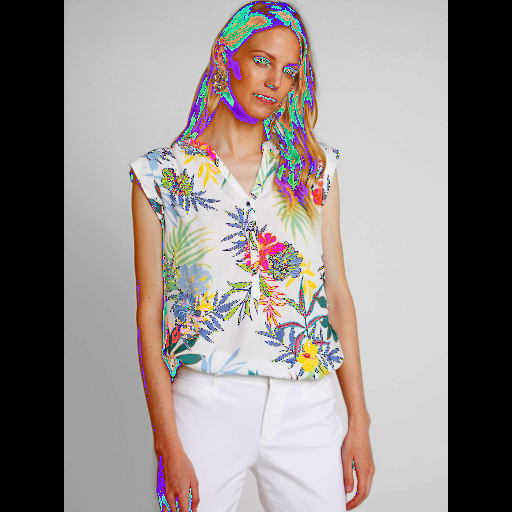

In [33]:
print(sample_viton['jpg'][0].shape)
to_pil_image = ToPILImage()
img = to_pil_image(sample_viton["jpg"][0].permute(2,0,1))

# Display the image
img.show()

torch.Size([224, 224, 3])


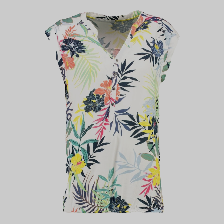

In [34]:
print(sample_viton['ref'][0].shape)
to_pil_image = ToPILImage()
img = to_pil_image(sample_viton["ref"][0].permute(2,0,1))

# Display the image
img.show()

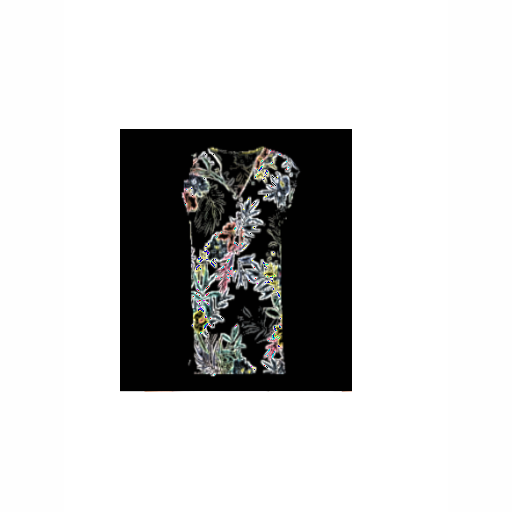

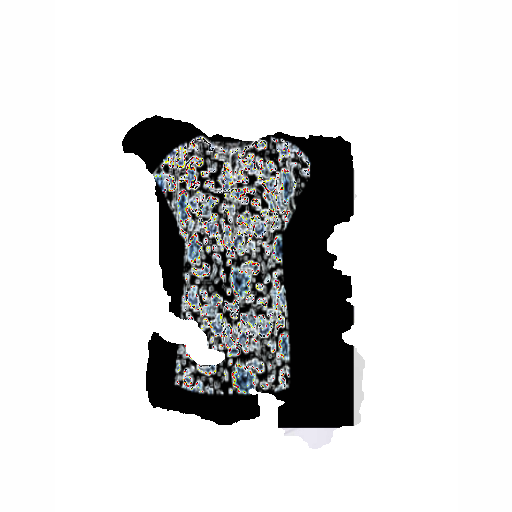

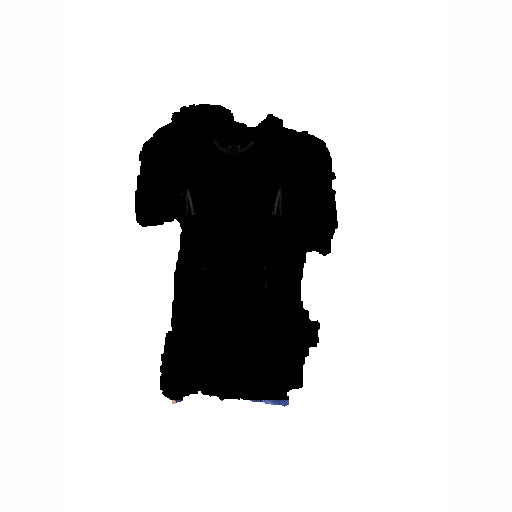

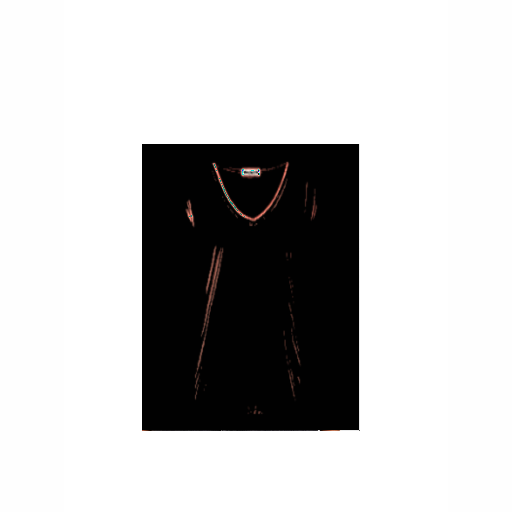

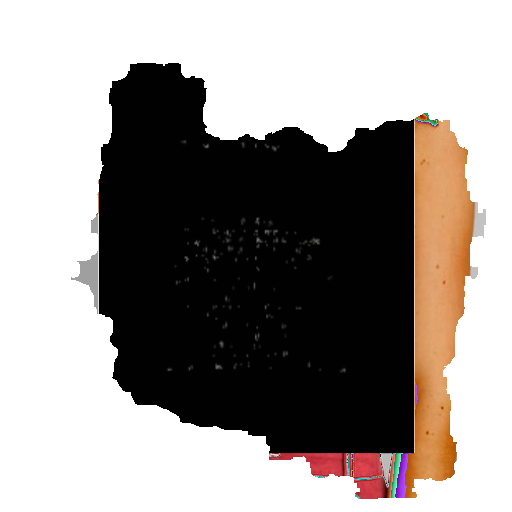

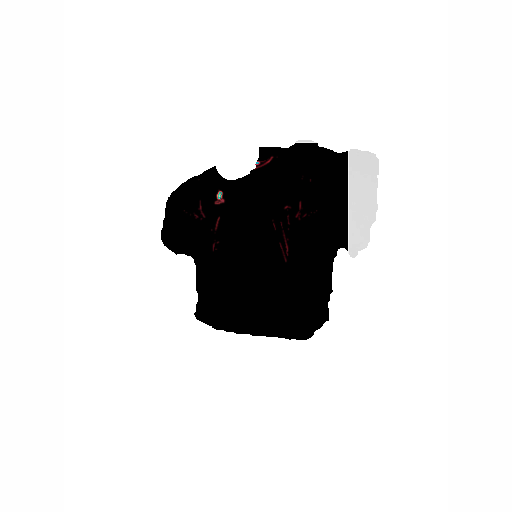

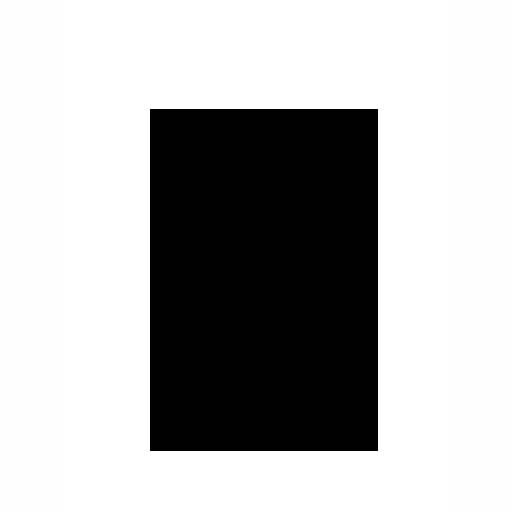

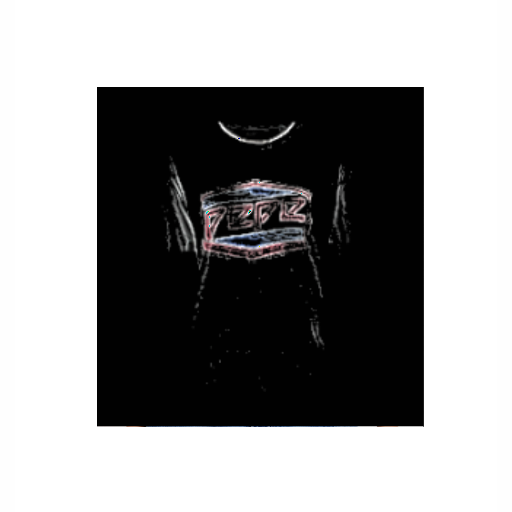

In [35]:
for sample in sample_viton['hint']:
    to_pil_image = ToPILImage()
    img = to_pil_image(sample.permute(2,0,1))

    # Display the image
    img.show()

## Create a new filter for garment

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def segment_garment(image_array):
    # Get the height and width of the image
    height, width, _ = image_array.shape

    # Sample the color of the corners, assuming they are part of the background
    corner_colors = np.array([
        image_array[0, 0],         # Top left corner
        image_array[0, width - 1], # Top right corner
        image_array[height - 1, 0],       # Bottom left corner
        image_array[height - 1, width - 1] # Bottom right corner
    ])
    
    # Compute the average background color
    background_color = np.mean(corner_colors, axis=0)

    # Compute the Euclidean distance from each pixel to the average background color
    color_distance = np.sqrt(((image_array.astype(np.float32) - background_color)**2).sum(axis=2))

    # Define a distance threshold
    distance_threshold = 30  # Adjust this threshold as needed

    # Create a mask where pixels with a distance greater than the threshold are considered foreground
    garment_mask = color_distance > distance_threshold

    # Convert the boolean mask to a binary mask
    garment_mask = (garment_mask * 255).astype(np.uint8)

    # Optional: Apply morphological operations to clean up the mask
    kernel = np.ones((5,5), np.uint8)
    garment_mask = cv2.morphologyEx(garment_mask, cv2.MORPH_OPEN, kernel)
    garment_mask = cv2.morphologyEx(garment_mask, cv2.MORPH_CLOSE, kernel)

    return garment_mask

# Example usage
image_path = '/home/ubuntu/mnt/myvolume/DressCode/lower_body/images/016162_1.jpg'  # Replace with your image path
# Load the image using matplotlib
image = mpimg.imread(image_path)
mask = segment_garment(image)
plt.imshow(mask, cmap='gray')  # Show the mask
plt.show()


In [ ]:
sample = next(sample_it)

In [ ]:
to_pil_image = ToPILImage()
for ref_image in sample["ref_image"]:
    img = to_pil_image(ref_image.permute(2,0,1))
    img.thumbnail((128,128))
    # Display the image
    img.show()

In [ ]:
for mask in sample["ref_mask"]:
    plt.imshow(mask, cmap='gray')  # Show the mask
    plt.show()

## Sample for the old DressCode Dataset class

In [ ]:
sample["cloth"][0].permute(2,1,0).shape

In [ ]:
print(sample["model_image"][0].shape)
to_pil_image = ToPILImage()
img = to_pil_image(sample["model_image"][0].permute(2,0,1))

# Display the image
img.show()

In [ ]:
to_pil_image = ToPILImage()
img = to_pil_image(sample["cloth"][0].permute(2,0,1))

# Display the image
img.show()

In [ ]:
to_pil_image = ToPILImage()
img = to_pil_image(sample["cloth"][0])

# Display the image
img.show()

In [ ]:
print(sample["model_mask"][0].shape)
plt.imshow(sample["model_mask"][0])
plt.show()

In [ ]:
sample["ref_mask"].shape

In [ ]:
mask = sample["ref_mask"][0]
plt.imshow(mask)
plt.show()

In [ ]:
to_pil_image = ToPILImage()
img = to_pil_image(sample["m"][0])

# Display the image
img.show()

In [ ]:
grayscale_transform = Grayscale(num_output_channels=1)
gray_tensor = grayscale_transform(sample["cloth"][0])

In [ ]:
threshold = 0.5
mask_tensor = gray_tensor < threshold

# Convert the boolean mask back to an image for visualization
to_pil_image = ToPILImage()
mask_image = to_pil_image(mask_tensor.float())

# Display the mask
mask_image.show()

In [ ]:
for key in ["cloth"]:
    plt.imshow(sample[key][0], interpolation='nearest')
    plt.show()

In [ ]:
ref_image = cv2.imread('/home/ubuntu/mnt/myvolume/DressCode/dresses/images/020716_1.jpg')
ref_image = cv2.cvtColor(ref_image, cv2.COLOR_BGR2RGB)
ref_mask = (ref_image < 255).astype(np.uint8)[:, :, 0]
model_image = cv2.imread('/home/ubuntu/mnt/myvolume/DressCode/dresses/images/020716_0.jpg')
model_image = cv2.cvtColor(model_image, cv2.COLOR_BGR2RGB)

plt.imshow(model_image)
plt.show()